# OSM DATA

###Load OSM Data

In [0]:
from pyspark.sql import functions as F
from pyspark.sql.functions import col, when, lit

# --- 1. CONFIGURATION ---
# The Storage Account and Container based on "lab94290/submissions"
storage_account_name = "lab94290"
container_name = "submissions"
group_folder = "Dekel_Amit_Shoval/OSM"

# The SAS Token provided (allowing access from anywhere)
sas_token = "sp=rle&st=2026-01-25T10:55:58Z&se=2026-03-01T19:10:58Z&spr=https&sv=2024-11-04&sr=c&sig=jgt2r2TSHpDaCyEfTEgHAfkvEvy49xReFDS4Mg9KnOA%3D"

# Configure Spark to use this SAS token for this specific container
spark.conf.set(
    f"fs.azure.sas.{container_name}.{storage_account_name}.blob.core.windows.net",
    sas_token
)

# Construct the absolute WASBS URL (Standard Spark-Azure protocol)
BASE_PATH = f"wasbs://{container_name}@{storage_account_name}.blob.core.windows.net/{group_folder}"

CITY_FILES = {
    "amsterdam": "Amsterdam",
    "bangkok": "Bangkok",
    "dubai": "Dubai",
    "eilat": "Eilat",
    "haifa": "Haifa",
    "london": "London",
    "new_york_city": "New York",
    "rome": "Rome",
    "tel_aviv": "Tel Aviv",
    "tokyo": "Tokyo",
}

osm_dfs = []

print(f"Loading OSM files from: {BASE_PATH}")
print("-" * 50)

for file_name, canonical_name in CITY_FILES.items():
    # Construct the full cloud path
    path = f"{BASE_PATH}/{file_name}.csv"
    
    try:
        df = spark.read.csv(path, header=True, inferSchema=True)
        count = df.count()
        df = df.withColumn("city", lit(canonical_name))
        osm_dfs.append(df)
        print(f"  ✓ {file_name}.csv: {count:,} records -> {canonical_name}")
    except Exception as e:
        # Cleaner error handling
        if "Path does not exist" in str(e) or "FileNotFoundException" in str(e):
            print(f"  ✗ {file_name}.csv: File not found.")
        elif "403" in str(e):
             print(f"  ✗ {file_name}.csv: Access Denied (Check SAS Token).")
        else:
            print(f"  ✗ {file_name}.csv: Error - {e}")

Loading OSM files from: wasbs://submissions@lab94290.blob.core.windows.net/Dekel_Amit_Shoval/OSM
--------------------------------------------------
  ✓ amsterdam.csv: 14,426 records -> Amsterdam
  ✓ bangkok.csv: 19,686 records -> Bangkok
  ✓ dubai.csv: 1,436 records -> Dubai
  ✓ eilat.csv: 795 records -> Eilat
  ✓ haifa.csv: 2,022 records -> Haifa
  ✓ london.csv: 35,388 records -> London
  ✓ new_york_city.csv: 26,767 records -> New York
  ✓ rome.csv: 23,851 records -> Rome
  ✓ tel_aviv.csv: 3,644 records -> Tel Aviv
  ✓ tokyo.csv: 34,972 records -> Tokyo


##Basic EDA

In [0]:
import os
import urllib.request

# CONFIGURATION 
# Source Details (Azure Blob HTTPS)
STORAGE_ACCOUNT = "lab94290"
CONTAINER = "submissions"
GROUP_FOLDER = "Dekel_Amit_Shoval/OSM"
# The token you provided
SAS_TOKEN = "sp=rle&st=2026-01-25T10:55:58Z&se=2026-03-01T19:10:58Z&spr=https&sv=2024-11-04&sr=c&sig=jgt2r2TSHpDaCyEfTEgHAfkvEvy49xReFDS4Mg9KnOA%3D"

# Construct the Base HTTPS URL
BASE_URL = f"https://{STORAGE_ACCOUNT}.blob.core.windows.net/{CONTAINER}/{GROUP_FOLDER}"

# Destination (Using the '/dbfs/' prefix for local file access)
DBFS_PATH = "/dbfs/FileStore/project/osm_raw"

CITY_FILES = [
    "amsterdam", "bangkok", "dubai", "eilat", "haifa",
    "london", "new_york_city", "rome", "tel_aviv", "tokyo"
]

# Create destination directory
os.makedirs(DBFS_PATH, exist_ok=True)

print(f"Copying files from Azure to {DBFS_PATH}")
print("-" * 60)

for file_name in CITY_FILES:
    # Format: https://account.blob.../file.csv?token
    source_url = f"{BASE_URL}/{file_name}.csv?{SAS_TOKEN}"
    
    # 2. Destination: Local File System Path
    dst_path = f"{DBFS_PATH}/{file_name}.csv"
    
    try:
        # urlretrieve downloads the remote file to the local path
        urllib.request.urlretrieve(source_url, dst_path)
        
        # Verify file size to ensure it's not empty
        size = os.path.getsize(dst_path)
        print(f" ✓ {file_name}.csv copied ({size/1024:.1f} KB)")
        
    except Exception as e:
        print(f" ✗ {file_name}.csv: Failed - {e}")

print("-" * 60)
print("Copy complete.")

Copying files from Azure to /dbfs/FileStore/project/osm_raw
------------------------------------------------------------
 ✓ amsterdam.csv copied (1266.3 KB)
 ✓ bangkok.csv copied (1922.7 KB)
 ✓ dubai.csv copied (117.3 KB)
 ✓ eilat.csv copied (70.2 KB)
 ✓ haifa.csv copied (192.2 KB)
 ✓ london.csv copied (3031.4 KB)
 ✓ new_york_city.csv copied (2451.2 KB)
 ✓ rome.csv copied (2083.3 KB)
 ✓ tel_aviv.csv copied (337.3 KB)
 ✓ tokyo.csv copied (3010.6 KB)
------------------------------------------------------------
Copy complete.


In [0]:
# Now load from DBFS (after copying)
from pyspark.sql.functions import lit

DBFS_SPARK_PATH = "dbfs:/FileStore/project/osm_raw"

CITY_FILES = {
    "amsterdam": "Amsterdam",
    "bangkok": "Bangkok",
    "dubai": "Dubai",
    "eilat": "Eilat",
    "haifa": "Haifa",
    "london": "London",
    "new_york_city": "New York",
    "rome": "Rome",
    "tel_aviv": "Tel Aviv",
    "tokyo": "Tokyo",
}

osm_dfs = []

for file_name, canonical_name in CITY_FILES.items():
    path = f"{DBFS_SPARK_PATH}/{file_name}.csv"
    df = spark.read.csv(path, header=True, inferSchema=True)
    df = df.withColumn("city", lit(canonical_name))
    osm_dfs.append(df)
    print(f"  {file_name}.csv loaded -> {canonical_name}")

osm_raw = osm_dfs[0]
for df in osm_dfs[1:]:
    osm_raw = osm_raw.unionByName(df, allowMissingColumns=True)

print(f"\nTotal OSM records: {osm_raw.count():,}")

  amsterdam.csv loaded -> Amsterdam
  bangkok.csv loaded -> Bangkok
  dubai.csv loaded -> Dubai
  eilat.csv loaded -> Eilat
  haifa.csv loaded -> Haifa
  london.csv loaded -> London
  new_york_city.csv loaded -> New York
  rome.csv loaded -> Rome
  tel_aviv.csv loaded -> Tel Aviv
  tokyo.csv loaded -> Tokyo

Total OSM records: 162,987


In [0]:
# Verify records per city
display(osm_raw.groupBy("city").count().orderBy("city"))

city,count
Amsterdam,14426
Bangkok,19686
Dubai,1436
Eilat,795
Haifa,2022
London,35388
New York,26767
Rome,23851
Tel Aviv,3644
Tokyo,34972


In [0]:
# Check schema
print("OSM Schema:")
print("-" * 50)
osm_raw.printSchema()
# Check category_group distribution
print("=== category_group distribution ===")
display(
    osm_raw
    .groupBy("category_group")
    .count()
    .orderBy(F.desc("count"))
)

OSM Schema:
--------------------------------------------------
root
 |-- source_city: string (nullable = true)
 |-- category_group: string (nullable = true)
 |-- name: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: double (nullable = true)
 |-- amenity: string (nullable = true)
 |-- public_transport: string (nullable = true)
 |-- highway: string (nullable = true)
 |-- railway: string (nullable = true)
 |-- leisure: string (nullable = true)
 |-- tourism: string (nullable = true)
 |-- historic: string (nullable = true)
 |-- building: string (nullable = true)
 |-- city: string (nullable = false)

=== category_group distribution ===


category_group,count
sustenance,67487
transport,34260
parks,31704
amenities,15661
attractions,12111
entertainment,1763
35.6881736,1


### Values Distribution

In [0]:
# Check amenity values (top 40)
print("=== Top 40 amenity values ===")
display(
    osm_raw
    .filter(col("amenity").isNotNull())
    .groupBy("amenity")
    .count()
    .orderBy(F.desc("count"))
    .limit(40)
)
# Check public_transport values
print("=== public_transport values ===")
display(
    osm_raw
    .filter(col("public_transport").isNotNull())
    .groupBy("public_transport")
    .count()
    .orderBy(F.desc("count"))
)

# Check railway values
print("=== railway values ===")
display(
    osm_raw
    .filter(col("railway").isNotNull())
    .groupBy("railway")
    .count()
    .orderBy(F.desc("count"))
)

# Check leisure values
print("=== leisure values ===")
display(
    osm_raw
    .filter(col("leisure").isNotNull())
    .groupBy("leisure")
    .count()
    .orderBy(F.desc("count"))
)
# Check tourism values
print("=== tourism values ===")
display(
    osm_raw
    .filter(col("tourism").isNotNull())
    .groupBy("tourism")
    .count()
    .orderBy(F.desc("count"))
)
# Check historic values
print("=== historic values ===")
display(
    osm_raw
    .filter(col("historic").isNotNull())
    .groupBy("historic")
    .count()
    .orderBy(F.desc("count"))
)

=== Top 40 amenity values ===


amenity,count
restaurant,31255
cafe,14471
fast_food,10606
pub,5868
bar,5053
school,4720
pharmacy,3266
atm,2818
bank,2781
theatre,851


=== public_transport values ===


public_transport,count
platform,28751
stop_position,3424
station,1773
platform;stop_position,1


=== railway values ===


railway,count
stop,3338
station,1308
halt,44
tram_stop,34
proposed,24
construction,15
train_station_entrance,3
site,2
monorail,2
subway_entrance,2


=== leisure values ===


leisure,count
garden,24578
park,7034
nature_reserve,95
amusement_arcade,19
dance,14
stadium,10
sports_centre,7
bird_hide,6
playground,5
pitch,4


=== tourism values ===


tourism,count
artwork,4390
attraction,1384
museum,949
viewpoint,527
zoo,44
theme_park,38
hotel,19
yes,16
information,11
guest_house,7


=== historic values ===


historic,count
memorial,4029
ruins,434
monument,411
castle,138
archaeological_site,45
yes,35
building,28
ship,18
tomb,12
heritage,5


### Categorize POI

In [0]:
from pyspark.sql import functions as F
from pyspark.sql.functions import col, when, lit

# POI Categorization based on actual data values
osm_categorized = osm_raw.withColumn(
    "poi_category",
    when(
        # NIGHTLIFE (noise sources)
        col("amenity").isin("bar", "pub", "nightclub", "casino"),
        "nightlife"
    ).when(
        # RESTAURANTS
        col("amenity").isin("restaurant", "fast_food", "food_court"),
        "restaurant"
    ).when(
        # CAFES
        col("amenity").isin("cafe"),
        "cafe"
    ).when(
        # PUBLIC TRANSPORT - Station (metro/train)
        (col("public_transport") == "station") |
        (col("railway").isin("station", "subway", "subway_entrance")),
        "transit_station"
    ).when(
        # PUBLIC TRANSPORT - Bus/Tram stops
        (col("public_transport").isin("platform", "stop_position")) |
        (col("amenity") == "bus_station") |
        (col("railway").isin("tram_stop", "halt")),
        "transit_stop"
    ).when(
        # FERRY
        col("amenity") == "ferry_terminal",
        "ferry"
    ).when(
        # LEISURE - Parks & Gardens
        col("leisure").isin("park", "garden", "nature_reserve"),
        "park"
    ).when(
        # LEISURE - Sports & Entertainment
        col("leisure").isin("stadium", "sports_centre", "fitness_centre", "swimming_pool", 
                           "water_park", "ice_rink", "amusement_arcade"),
        "sports_entertainment"
    ).when(
        # TOURISM - Attractions
        col("tourism").isin("attraction", "viewpoint", "theme_park", "zoo"),
        "tourist_attraction"
    ).when(
        # TOURISM - Museums & Art
        col("tourism").isin("museum", "gallery", "artwork"),
        "museum_art"
    ).when(
        # HISTORIC
        col("historic").isin("memorial", "monument", "castle", "ruins", 
                            "archaeological_site", "fort", "tomb"),
        "historic_site"
    ).when(
        # ENTERTAINMENT - Theatre & Cinema
        col("amenity").isin("theatre", "cinema", "arts_centre"),
        "entertainment"
    ).when(
        # CONVENIENCE - Health
        col("amenity").isin("pharmacy", "hospital"),
        "health"
    ).when(
        # CONVENIENCE - Finance
        col("amenity").isin("bank", "atm"),
        "finance"
    ).when(
        # CONVENIENCE - Shopping
        col("amenity") == "marketplace",
        "shopping"
    ).when(
        # EDUCATION
        col("amenity").isin("school", "university", "library"),
        "education"
    ).when(
        # MAJOR ROADS (noise)
        col("highway").isin("primary", "secondary", "trunk", "motorway"),
        "major_road"
    ).otherwise("other")
)

# Create higher-level groupings for gap analysis
osm_categorized = osm_categorized.withColumn(
    "poi_group",
    when(
        col("poi_category").isin("nightlife", "major_road"),
        "noise_source"
    ).when(
        col("poi_category").isin("transit_station", "transit_stop", "ferry"),
        "transport"
    ).when(
        col("poi_category").isin("park", "sports_entertainment"),
        "leisure"
    ).when(
        col("poi_category").isin("tourist_attraction", "museum_art", "historic_site", "entertainment"),
        "tourism"
    ).when(
        col("poi_category").isin("restaurant", "cafe"),
        "dining"
    ).when(
        col("poi_category").isin("health", "finance", "shopping"),
        "convenience"
    ).when(
        col("poi_category") == "education",
        "education"
    ).otherwise("other")
)

print("Categorization complete!")

Categorization complete!


In [0]:
# Check POI category distribution
print("=== POI Category Distribution ===")
display(
    osm_categorized
    .groupBy("poi_category")
    .count()
    .orderBy(F.desc("count"))
)
# Check POI group distribution (high-level)
print("=== POI Group Distribution ===")
display(
    osm_categorized
    .groupBy("poi_group")
    .count()
    .orderBy(F.desc("count"))
)
# Distribution by city and group (pivot table)
print("=== POI Groups by City ===")
display(
    osm_categorized
    .groupBy("city", "poi_group")
    .count()
    .groupBy("city")
    .pivot("poi_group")
    .sum("count")
    .orderBy("city")
)
# Check noise sources specifically (important for gap analysis)
print("=== Noise Sources by City ===")
display(
    osm_categorized
    .filter(col("poi_group") == "noise_source")
    .groupBy("city", "poi_category")
    .count()
    .orderBy("city", F.desc("count"))
)
# Check transport by city
print("=== Transport by City ===")
display(
    osm_categorized
    .filter(col("poi_group") == "transport")
    .groupBy("city", "poi_category")
    .count()
    .orderBy("city", F.desc("count"))
)

=== POI Category Distribution ===


poi_category,count
restaurant,42094
transit_stop,32168
park,31706
cafe,14471
nightlife,11496
education,6157
finance,5599
museum_art,5333
historic_site,4828
health,3889


=== POI Group Distribution ===


poi_group,count
dining,56565
transport,33950
leisure,31731
tourism,13248
noise_source,11496
convenience,9488
education,6157
other,352


=== POI Groups by City ===


city,convenience,dining,education,leisure,noise_source,other,tourism,transport
Amsterdam,419,3385,396,6765,651,34,1495,1281
Bangkok,1895,7526,809,3377,795,216,1088,3980
Dubai,136,650,56,383,49,18,45,99
Eilat,26,107,32,283,11,1,73,262
Haifa,64,257,82,229,33,2,98,1257
London,1748,12297,1428,6916,2928,20,3570,6481
New York,1278,9616,898,6903,1556,3,1481,5032
Rome,1361,6190,1016,3422,714,8,2031,9109
Tel Aviv,193,1008,100,716,207,2,346,1072
Tokyo,2368,15529,1340,2737,4552,48,3021,5377


=== Noise Sources by City ===


city,poi_category,count
Amsterdam,nightlife,651
Bangkok,nightlife,795
Dubai,nightlife,49
Eilat,nightlife,11
Haifa,nightlife,33
London,nightlife,2928
New York,nightlife,1556
Rome,nightlife,714
Tel Aviv,nightlife,207
Tokyo,nightlife,4552


=== Transport by City ===


city,poi_category,count
Amsterdam,transit_stop,1214
Amsterdam,transit_station,67
Bangkok,transit_stop,3674
Bangkok,transit_station,306
Dubai,transit_stop,87
Dubai,transit_station,12
Eilat,transit_stop,260
Eilat,transit_station,2
Haifa,transit_stop,1229
Haifa,transit_station,28


## Clean and prepare for spatial Joins

In [0]:
# Select relevant columns and filter POIs with coordinates
osm_clean = osm_categorized.select(
    "city",
    "name",
    "latitude",
    "longitude",
    "poi_category",
    "poi_group",
    # Keep original columns for debugging
    "amenity",
    "public_transport",
    "railway",
    "leisure",
    "tourism",
    "historic",
    "highway"
).filter(
    col("latitude").isNotNull() & 
    col("longitude").isNotNull()
).withColumnRenamed(
    "latitude", "lat"
).withColumnRenamed(
    "longitude", "lon"
)

print(f"OSM POIs with coordinates: {osm_clean.count():,}")
display(osm_clean.groupBy("city").count().orderBy("city"))

OSM POIs with coordinates: 162,985


city,count
Amsterdam,14426
Bangkok,19686
Dubai,1436
Eilat,795
Haifa,2022
London,35388
New York,26767
Rome,23851
Tel Aviv,3644
Tokyo,34970


In [0]:
# Verify we have noise sources for gap analysis
print("=== Noise Sources with Coordinates ===")
display(
    osm_clean
    .filter(col("poi_group") == "noise_source")
    .groupBy("city")
    .count()
    .orderBy("city")
)
# Save to Silver layer
osm_clean.write \
    .mode("overwrite") \
    .partitionBy("city") \
    .parquet("dbfs:/FileStore/project/silver/osm_clean")

print("Saved to: dbfs:/FileStore/project/silver/osm_clean")

# Verify save
display(dbutils.fs.ls("dbfs:/FileStore/project/silver/osm_clean"))

=== Noise Sources with Coordinates ===


city,count
Amsterdam,651
Bangkok,795
Dubai,49
Eilat,11
Haifa,33
London,2928
New York,1556
Rome,714
Tel Aviv,207
Tokyo,4552


Saved to: dbfs:/FileStore/project/silver/osm_clean


path,name,size,modificationTime
dbfs:/FileStore/project/silver/osm_clean/_SUCCESS,_SUCCESS,0,1769453309000
dbfs:/FileStore/project/silver/osm_clean/_committed_3230289733384661978,_committed_3230289733384661978,35,1768988606000
dbfs:/FileStore/project/silver/osm_clean/city=Amsterdam/,city=Amsterdam/,0,1768924960000
dbfs:/FileStore/project/silver/osm_clean/city=Bangkok/,city=Bangkok/,0,1768924960000
dbfs:/FileStore/project/silver/osm_clean/city=Dubai/,city=Dubai/,0,1768924960000
dbfs:/FileStore/project/silver/osm_clean/city=Eilat/,city=Eilat/,0,1768924960000
dbfs:/FileStore/project/silver/osm_clean/city=Haifa/,city=Haifa/,0,1768924960000
dbfs:/FileStore/project/silver/osm_clean/city=London/,city=London/,0,1768924961000
dbfs:/FileStore/project/silver/osm_clean/city=New York/,city=New York/,0,1768924961000
dbfs:/FileStore/project/silver/osm_clean/city=Rome/,city=Rome/,0,1768924961000


#Google maps


## Load Data and save tp DFBS


In [0]:
import os
import urllib.request

# --- 1. CONFIGURATION ---
# Azure Storage Details
STORAGE_ACCOUNT = "lab94290"
CONTAINER = "submissions"
# Updated folder path to Google_Maps
GROUP_FOLDER = "Dekel_Amit_Shoval/Google_Maps"

# The SAS Token you provided earlier
SAS_TOKEN = "sp=rle&st=2026-01-25T10:55:58Z&se=2026-03-01T19:10:58Z&spr=https&sv=2024-11-04&sr=c&sig=jgt2r2TSHpDaCyEfTEgHAfkvEvy49xReFDS4Mg9KnOA%3D"

# Construct the Base HTTPS URL
BASE_URL = f"https://{STORAGE_ACCOUNT}.blob.core.windows.net/{CONTAINER}/{GROUP_FOLDER}"

# Destination Path (Local DBFS)
DBFS_PATH = "/dbfs/FileStore/project/gmaps_raw"

# Updated list of files
CITY_FILES = [
    "amsterdam_final",
    "bangkok_final",
    "dubai_final",
    "eilat_final",
    "london_final",
    "rome_final",
    "tokyo_final"
]

# Create destination directory
os.makedirs(DBFS_PATH, exist_ok=True)

print(f"Copying Google Maps files to: {DBFS_PATH}")
print("-" * 60)

for file_name in CITY_FILES:
    # 1. Source: Full URL + SAS Token
    # Construct: https://.../Google_Maps/amsterdam_final.csv?token
    source_url = f"{BASE_URL}/{file_name}.csv?{SAS_TOKEN}"
    
    # 2. Destination: Local Path
    dst_path = f"{DBFS_PATH}/{file_name}.csv"
    
    try:
        # Download the file
        urllib.request.urlretrieve(source_url, dst_path)
        
        # Check size to confirm success
        size_kb = os.path.getsize(dst_path) / 1024
        print(f"  ✓ {file_name}.csv copied ({size_kb:.1f} KB)")
        
    except Exception as e:
        # HTTP 404 means file not found
        if "404" in str(e):
            print(f"  ✗ {file_name}.csv: File not found in cloud folder.")
        else:
            print(f"  ✗ {file_name}.csv: Failed - {e}")

print("\nDone!")

Copying Google Maps files to: /dbfs/FileStore/project/gmaps_raw
------------------------------------------------------------
  ✓ amsterdam_final.csv copied (9860.1 KB)
  ✓ bangkok_final.csv copied (15914.7 KB)
  ✓ dubai_final.csv copied (20180.2 KB)
  ✓ eilat_final.csv copied (4206.0 KB)
  ✓ london_final.csv copied (16762.0 KB)
  ✓ rome_final.csv copied (10765.1 KB)
  ✓ tokyo_final.csv copied (18635.2 KB)

Done!


In [0]:
# Verify files are in DBFS
display(dbutils.fs.ls("dbfs:/FileStore/project/gmaps_raw"))

path,name,size,modificationTime
dbfs:/FileStore/project/gmaps_raw/amsterdam_final.csv,amsterdam_final.csv,10096764,1769453315000
dbfs:/FileStore/project/gmaps_raw/bangkok_final.csv,bangkok_final.csv,16296664,1769453315000
dbfs:/FileStore/project/gmaps_raw/dubai_final.csv,dubai_final.csv,20664479,1769453316000
dbfs:/FileStore/project/gmaps_raw/eilat_final.csv,eilat_final.csv,4306919,1769453317000
dbfs:/FileStore/project/gmaps_raw/rome_final.csv,rome_final.csv,11023491,1769453317000
dbfs:/FileStore/project/gmaps_raw/tokyo_final.csv,tokyo_final.csv,19082427,1769453318000


In [0]:
from pyspark.sql import functions as F
from pyspark.sql.functions import col, when, lit, lower

# Load from DBFS
GMAPS_SPARK_PATH = "dbfs:/FileStore/project/gmaps_raw"

# File name -> Canonical city name mapping
CITY_FILES = {
    "amsterdam_final": "Amsterdam",
    "bangkok_final": "Bangkok",
    "dubai_final": "Dubai",
    "eilat_final": "Eilat",
    "london_final": "London",
    "rome_final": "Rome",
    "tokyo_final": "Tokyo",
}

gmaps_dfs = []

print("Loading Google Maps files from DBFS:")
print("-" * 50)

for file_name, canonical_name in CITY_FILES.items():
    path = f"{GMAPS_SPARK_PATH}/{file_name}.csv"
    try:
        df = spark.read.csv(path, header=True, inferSchema=True)
        df = df.withColumn("city", lit(canonical_name))
        count = df.count()
        gmaps_dfs.append(df)
        print(f"  ✓ {file_name}.csv: {count:,} records -> {canonical_name}")
    except Exception as e:
        print(f"  ✗ {file_name}.csv: {e}")

# Union all DataFrames
gmaps_raw = gmaps_dfs[0]
for df in gmaps_dfs[1:]:
    gmaps_raw = gmaps_raw.unionByName(df, allowMissingColumns=True)

print(f"\n{'='*50}")
print(f"Total Google Maps records: {gmaps_raw.count():,}")

Loading Google Maps files from DBFS:
--------------------------------------------------
  ✓ amsterdam_final.csv: 2,088 records -> Amsterdam
  ✓ bangkok_final.csv: 2,811 records -> Bangkok
  ✓ dubai_final.csv: 2,389 records -> Dubai
  ✓ eilat_final.csv: 1,659 records -> Eilat
  ✓ london_final.csv: 2,315 records -> London
  ✓ rome_final.csv: 2,198 records -> Rome
  ✓ tokyo_final.csv: 2,515 records -> Tokyo

Total Google Maps records: 15,975


## EDA 

In [0]:
# Records per city
display(gmaps_raw.groupBy("city").count().orderBy("city"))
# Check schema
print("Google Maps Schema:")
print("-" * 50)
gmaps_raw.printSchema()

city,count
Amsterdam,2088
Bangkok,2811
Dubai,2389
Eilat,1659
Rome,2198
Tokyo,2515


Google Maps Schema:
--------------------------------------------------
root
 |-- place_name: string (nullable = true)
 |-- url: string (nullable = true)
 |-- category: string (nullable = true)
 |-- main_category: string (nullable = true)
 |-- subcategory: string (nullable = true)
 |-- poi_type: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- num_of_reviews: integer (nullable = true)
 |-- reviews_content: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- city: string (nullable = false)



### Values Distribution

In [0]:
# Check main_category distribution
print("=== main_category distribution ===")
display(
    gmaps_raw
    .groupBy("main_category")
    .count()
    .orderBy(F.desc("count"))
)
# Check subcategory distribution (top 50)
print("=== Top 50 subcategory values ===")
display(
    gmaps_raw
    .groupBy("subcategory")
    .count()
    .orderBy(F.desc("count"))
    .limit(50)
)
# Check poi_type distribution
print("=== poi_type distribution ===")
display(
    gmaps_raw
    .groupBy("poi_type")
    .count()
    .orderBy(F.desc("count"))
)
# Cross-tab: main_category vs subcategory
print("=== Category hierarchy ===")
display(
    gmaps_raw
    .groupBy("main_category", "subcategory")
    .count()
    .orderBy("main_category", F.desc("count"))
    .limit(60)
)
# Check how many have reviews
reviews_count = gmaps_raw.filter(col("reviews_content").isNotNull()).count()
total_count = gmaps_raw.count()
print(f"POIs with reviews: {reviews_count:,} / {total_count:,} ({reviews_count/total_count*100:.1f}%)")
# Sample reviews to understand format
display(
    gmaps_raw
    .filter(col("reviews_content").isNotNull())
    .select("place_name", "main_category", "subcategory", "rating", "num_of_reviews", "reviews_content")
    .limit(5)
)

=== main_category distribution ===


main_category,count
Entertainment-Activities,1550
Dining,1415
Parks-Recreation,1177
Wellness-Spa,1160
Work-Remote,1156
Experiences-Tours,1095
Family-Kids,1085
Experiences-Activities,1026
Entertainment-Culture,1021
Nightlife-Bars,995


=== Top 50 subcategory values ===


subcategory,count
Adventure,614
Water,597
Entertainment,595
Coworking,585
Bath,583
Spa,577
Play,548
Markets,524
Games,485
Restaurant,482


=== poi_type distribution ===


poi_type,count
Wine tasting,243
Day spa,229
Private office,227
Spa,209
Coworking space,208
Cocktail bar,207
Playground,200
Scenic spot,196
Cafe with wifi,188
Arcade,188


=== Category hierarchy ===


main_category,subcategory,count
Dining,Restaurant,482
Dining,Fast_Food,475
Dining,Cafe,458
Entertainment-Activities,Games,485
Entertainment-Activities,Performance,394
Entertainment-Activities,Amusement,385
Entertainment-Activities,Theater,286
Entertainment-Culture,Landmarks,395
Entertainment-Culture,Museums,389
Entertainment-Culture,Galleries,237


POIs with reviews: 11,089 / 13,660 (81.2%)


place_name main_category subcategory rating num_of_reviews reviews_content Amsterdam Catacombs Escape Room Entertainment-Activities Games 4.9 757 Visited the Amsterdam Catacombs today as a first-timer with group of 4, and it was an amazing experience. The atmosphere was tense and immersive from the moment we stepped inside. The story background was incredibly well-crafted, and it really pulled us into the mystery. The actors did a fantastic job, they made everything feel real and added just the right amount of fear and thrill. Overall, I had a great time and would definitely recommend it to anyone who enjoys escape rooms or wants a unique, cinematic adventure in Amsterdam. || So much fun! The actors were very dedicated and really helped you to feel immersed in the experience. It was quite scary at times even though we didn't expect to be scared at all 😅. Very much worth the money and would recommend to anyone. || This was fantastic! The actors were amazing and made the whole experience immersive. One of us was terrified, so we used the safe word, and they were very understanding. They even went out of their way to go over the time and give us a shorter version of the rest of the experience. Absolutely recommended. || Soooo worthhhh ittttttt, a must at least once experience, the puzzles are not too hard or too easy so everyone can do it. Try to be more aware and listen to everything inside because some clues are in what they tell you. Extremely recommended. || Wow. The most immersing and convincing escape room I've ever done. The actors were really incredible from the beginning. The story was interesting and the theme was on point. Really exciting how it evolved. A very memorable experience especially for a horror fan - to be IN the story. Couldn't recommend enough. || It was an amazing experience! I had a special request for our visit, and the team was extremely helpful and more than happy to help from the hosts to the Manager Katarína. We loved every minute of the Game, which is very thrilling, exciting, but mostly fun to do! Definitely make sure to visit the Catacombs when you’re in Amsterdam. || Great experience! Fun, spooky, and perfectly balancing clues, puzzles, and the scariness. Would recommend to everyone who is looking for a fun new activity with a little extra shot of adrenaline. || What a fantastic experience! I was slightly apprehensive about the scare factor but it was pitched just right though I did leave with a slightly sore throat from screaming. The hosts are amazing and play their parts perfectly. You won’t regret going || Fantastic. We've been to many escape rooms before, but this is a special one. Logic Lock did a great job, and the actors were great as well. (We did the horror room). || Absolutely amazing! The Catacombs escape room in Amsterdam was one of the most intense and exciting experiences I’ve ever had. The real catacomb setting creates a chilling atmosphere right from the start. The puzzles are clever, creative, and seamlessly integrated into the story – it feels more like an adventure or a movie than a typical escape room. What really stood out is the combination of acting, sound, and lighting, which makes the whole experience feel incredibly real. You’re fully immersed the entire time and completely forget it’s “just” a game. A must-do for any escape room fan – definitely one of the highlights in Amsterdam! the_esc_apes || This is one of the beat escape rooms of my life. The atmosphere is phenomenal and the build up was masterfully created. We ended up releasing the evil into the world, but that was for orher to trap it back. Absolutely loved jt. || This was such an awesome time! The puzzles were great, acting was stellar, and jump scares galore. My husband and I have been to a few escape rooms in the states but none match this one. || If you love a good scare, demons, and solving mysteries you have to give this place a try! This place is terrifying and amazing. It’s truly not like any other es

In [0]:
# Rating distribution by main_category
print("=== Ratings by main_category ===")
display(
    gmaps_raw
    .groupBy("main_category")
    .agg(
        F.count("*").alias("count"),
        F.round(F.avg("rating"), 2).alias("avg_rating"),
        F.round(F.avg("num_of_reviews"), 0).alias("avg_num_reviews"),
        F.sum("num_of_reviews").alias("total_reviews")
    )
    .orderBy(F.desc("count"))
)
# Check nightlife/bars specifically (important for noise detection)
print("=== Bars & Nightlife Details ===")
display(
    gmaps_raw
    .filter(
        lower(col("main_category")).contains("bar") |
        lower(col("subcategory")).contains("bar") |
        lower(col("subcategory")).contains("club") |
        lower(col("subcategory")).contains("night") |
        lower(col("subcategory")).contains("pub") |
        lower(col("subcategory")).contains("lounge")
    )
    .groupBy("city", "subcategory")
    .agg(
        F.count("*").alias("count"),
        F.round(F.avg("rating"), 2).alias("avg_rating"),
        F.round(F.avg("num_of_reviews"), 0).alias("avg_reviews")
    )
    .orderBy("city", F.desc("count"))
)

=== Ratings by main_category ===


main_category,count,avg_rating,avg_num_reviews,total_reviews
Entertainment-Activities,1550,4.44,3289.0,5098201
Dining,1415,4.56,1829.0,2588373
Parks-Recreation,1177,4.39,7351.0,8652110
Wellness-Spa,1160,4.6,946.0,1097636
Work-Remote,1156,4.52,779.0,900723
Experiences-Tours,1095,4.73,891.0,975313
Family-Kids,1085,4.37,2083.0,2260222
Experiences-Activities,1026,4.5,817.0,838498
Entertainment-Culture,1021,4.46,8449.0,8626685
Nightlife-Bars,995,4.6,902.0,897717


=== Bars & Nightlife Details ===


city,subcategory,count,avg_rating,avg_reviews
Amsterdam,Wine,66,4.81,322.0
Amsterdam,Specialty,36,4.42,1815.0
Amsterdam,Cocktail,28,4.38,930.0
Bangkok,Specialty,105,4.51,982.0
Bangkok,Cocktail,66,4.86,523.0
Bangkok,Wine,51,4.78,228.0
Bangkok,Pub,47,4.59,764.0
Dubai,Wine,62,4.74,1041.0
Dubai,Specialty,50,4.61,1778.0
Dubai,Cocktail,34,4.68,1027.0


## Calculate Metrics 

In [0]:
from pyspark.sql import functions as F
from pyspark.sql.functions import col, when, lit, lower, split, size

# Reload from DBFS with city column
GMAPS_SPARK_PATH = "dbfs:/FileStore/project/gmaps_raw"

CITY_FILES = {
    "amsterdam_final": "Amsterdam",
    "bangkok_final": "Bangkok",
    "dubai_final": "Dubai",
    "eilat_final": "Eilat",
    "rome_final": "Rome",
    "tokyo_final": "Tokyo",
}

gmaps_dfs = []

print("Loading Google Maps files from DBFS:")
print("-" * 50)

for file_name, canonical_name in CITY_FILES.items():
    path = f"{GMAPS_SPARK_PATH}/{file_name}.csv"
    try:
        df = spark.read.csv(path, header=True, inferSchema=True)
        df = df.withColumn("city", lit(canonical_name))
        count = df.count()
        gmaps_dfs.append(df)
        print(f"  ✓ {file_name}.csv: {count:,} records -> {canonical_name}")
    except Exception as e:
        print(f"  ✗ {file_name}.csv: {e}")

# Union all DataFrames
gmaps_raw = gmaps_dfs[0]
for df in gmaps_dfs[1:]:
    gmaps_raw = gmaps_raw.unionByName(df, allowMissingColumns=True)

print(f"\n{'='*50}")
print(f"Total Google Maps records: {gmaps_raw.count():,}")

# Verify city column exists
display(gmaps_raw.groupBy("city").count().orderBy("city"))

Loading Google Maps files from DBFS:
--------------------------------------------------
  ✓ amsterdam_final.csv: 2,088 records -> Amsterdam
  ✓ bangkok_final.csv: 2,811 records -> Bangkok
  ✓ dubai_final.csv: 2,389 records -> Dubai
  ✓ eilat_final.csv: 1,659 records -> Eilat
  ✓ rome_final.csv: 2,198 records -> Rome
  ✓ tokyo_final.csv: 2,515 records -> Tokyo

Total Google Maps records: 13,660


city,count
Amsterdam,2088
Bangkok,2811
Dubai,2389
Eilat,1659
Rome,2198
Tokyo,2515


### POI Gap 

In [0]:
# Categorize POIs for gap analysis
gmaps_categorized = gmaps_raw.withColumn(
    "poi_category",
    when(
        # NIGHTLIFE - High noise potential
        (col("main_category") == "Nightlife-Clubs") |
        (col("subcategory").isin("Dance", "Entertainment")) & (col("main_category") == "Nightlife-Clubs"),
        "nightclub"
    ).when(
        # BARS - Medium-high noise potential
        col("main_category") == "Nightlife-Bars",
        "bar"
    ).when(
        # RESTAURANTS
        col("main_category") == "Dining",
        "restaurant"
    ).when(
        # CAFES
        (col("main_category") == "Work-Remote") & (col("subcategory").isin("Cafes", "Business")),
        "cafe"
    ).when(
        # PARKS & NATURE
        col("main_category") == "Parks-Recreation",
        "park"
    ).when(
        # TOURIST ATTRACTIONS
        col("main_category") == "Entertainment-Culture",
        "tourist_attraction"
    ).when(
        # FAMILY FRIENDLY
        col("main_category") == "Family-Kids",
        "family_friendly"
    ).when(
        # WELLNESS
        col("main_category").isin("Wellness-Spa", "Wellness-Fitness"),
        "wellness"
    ).when(
        # SHOPPING
        col("main_category") == "Shopping-General",
        "shopping"
    ).when(
        # ENTERTAINMENT
        col("main_category") == "Entertainment-Activities",
        "entertainment"
    ).when(
        # EXPERIENCES/TOURS
        col("main_category").isin("Experiences-Tours", "Experiences-Activities"),
        "experiences"
    ).otherwise("other")
)

# Create higher-level grouping for gap analysis
gmaps_categorized = gmaps_categorized.withColumn(
    "poi_group",
    when(
        col("poi_category").isin("nightclub", "bar"),
        "nightlife"  # Noise sources
    ).when(
        col("poi_category") == "restaurant",
        "dining"
    ).when(
        col("poi_category").isin("park", "wellness"),
        "leisure"
    ).when(
        col("poi_category").isin("tourist_attraction", "entertainment", "experiences"),
        "tourism"
    ).when(
        col("poi_category") == "family_friendly",
        "family"
    ).when(
        col("poi_category").isin("shopping", "cafe"),
        "convenience"
    ).otherwise("other")
)

# Check categorization
print("=== POI Category Distribution ===")
display(
    gmaps_categorized
    .groupBy("poi_category")
    .agg(
        F.count("*").alias("count"),
        F.round(F.avg("rating"), 2).alias("avg_rating")
    )
    .orderBy(F.desc("count"))
)

=== POI Category Distribution ===


poi_category,count,avg_rating
experiences,2121,4.61
entertainment,1550,4.44
wellness,1451,4.61
restaurant,1415,4.56
park,1177,4.39
family_friendly,1085,4.37
tourist_attraction,1021,4.46
other,1018,4.55
bar,995,4.6
shopping,784,4.21


In [0]:
# Check POI group distribution
print("=== POI Group Distribution ===")
display(
    gmaps_categorized
    .groupBy("poi_group")
    .agg(
        F.count("*").alias("count"),
        F.round(F.avg("rating"), 2).alias("avg_rating"),
        F.sum("num_of_reviews").alias("total_reviews")
    )
    .orderBy(F.desc("count"))
)

=== POI Group Distribution ===


poi_group,count,avg_rating,total_reviews
tourism,4692,4.52,15538697
leisure,2628,4.51,9835439
nightlife,1467,4.53,1317392
dining,1415,4.56,2588373
convenience,1355,4.33,5843952
family,1085,4.37,2260222
other,1018,4.55,584098


### Reviews

In [0]:
# Split reviews into array and count them
gmaps_with_reviews = gmaps_categorized.withColumn(
    "reviews_array",
    when(
        col("reviews_content").isNotNull(),
        split(col("reviews_content"), " \\|\\| ")
    ).otherwise(F.array())
).withColumn(
    "num_scraped_reviews",
    size(col("reviews_array"))
)

# Check review counts
print("=== Reviews per POI ===")
display(
    gmaps_with_reviews
    .groupBy("poi_group")
    .agg(
        F.count("*").alias("num_pois"),
        F.sum(F.when(col("reviews_content").isNotNull(), 1).otherwise(0)).alias("pois_with_reviews"),
        F.round(F.avg("num_scraped_reviews"), 1).alias("avg_scraped_reviews"),
        F.sum("num_scraped_reviews").alias("total_scraped_reviews")
    )
    .orderBy(F.desc("num_pois"))
)

=== Reviews per POI ===


poi_group,num_pois,pois_with_reviews,avg_scraped_reviews,total_scraped_reviews
tourism,4692,3679,11.8,55455
leisure,2628,2037,13.8,36155
nightlife,1467,1285,18.5,27124
dining,1415,1390,22.5,31897
convenience,1355,1043,13.1,17789
family,1085,771,11.1,12000
other,1018,884,12.2,12453


####  Noise

In [0]:
# Define noise-related keywords
NOISE_KEYWORDS = {
    "high_noise": [
        "loud", "noisy", "party", "dancing", "dj", "music", "crowded", "packed",
        "lively", "energetic", "wild", "pumping", "bass", "club", "rave",
        "late night", "until morning", "3am", "4am", "5am", "all night"
    ],
    "low_noise": [
        "quiet", "calm", "relaxed", "chill", "peaceful", "cozy", "intimate",
        "romantic", "lounge", "wine bar", "conversation", "sophisticated",
        "mellow", "laid-back", "serene"
    ]
}

# Create regex patterns
high_noise_pattern = "|".join(NOISE_KEYWORDS["high_noise"])
low_noise_pattern = "|".join(NOISE_KEYWORDS["low_noise"])

# Extract noise signals from reviews
gmaps_with_noise = gmaps_with_reviews.withColumn(
    "reviews_lower",
    lower(col("reviews_content"))
).withColumn(
    "high_noise_mentions",
    F.size(F.expr(f"filter(split(reviews_lower, ' '), x -> x rlike '{high_noise_pattern}')"))
).withColumn(
    "low_noise_mentions", 
    F.size(F.expr(f"filter(split(reviews_lower, ' '), x -> x rlike '{low_noise_pattern}')"))
)

# Calculate noise score (higher = louder venue)
# Score: 0 (quiet) to 1 (very loud)
gmaps_with_noise = gmaps_with_noise.withColumn(
    "noise_score",
    when(
        (col("high_noise_mentions") + col("low_noise_mentions")) > 0,
        col("high_noise_mentions") / (col("high_noise_mentions") + col("low_noise_mentions") + 1)
    ).otherwise(
        # Default noise score based on category
        when(col("poi_category") == "nightclub", 0.8)
        .when(col("poi_category") == "bar", 0.5)
        .otherwise(0.2)
    )
)

# Check noise scores for nightlife
print("=== Noise Scores for Nightlife ===")
display(
    gmaps_with_noise
    .filter(col("poi_group") == "nightlife")
    .groupBy("city", "poi_category")
    .agg(
        F.count("*").alias("count"),
        F.round(F.avg("noise_score"), 2).alias("avg_noise_score"),
        F.round(F.avg("rating"), 2).alias("avg_rating"),
        F.sum("high_noise_mentions").alias("total_high_noise"),
        F.sum("low_noise_mentions").alias("total_low_noise")
    )
    .orderBy("city", "poi_category")
)
# Extract noise mentions first
gmaps_with_noise = gmaps_with_reviews.withColumn(
    "reviews_lower", lower(col("reviews_content"))
).withColumn(
    "high_noise_mentions",
    F.size(F.expr(f"filter(split(reviews_lower, ' '), x -> x rlike '{high_noise_pattern}')"))
).withColumn(
    "low_noise_mentions", 
    F.size(F.expr(f"filter(split(reviews_lower, ' '), x -> x rlike '{low_noise_pattern}')"))
)

# Define Defaults first
gmaps_with_noise = gmaps_with_noise.withColumn(
    "default_noise",
    when(col("poi_category") == "nightclub", 0.8)
    .when(col("poi_category") == "bar", 0.5)
    .otherwise(0.2)
)

# Apply calculation ONLY if we have meaningful data (e.g., > 2 mentions)
# Otherwise, stick to the default (or average the default with the evidence)
gmaps_with_noise = gmaps_with_noise.withColumn(
    "calculated_score",
    col("high_noise_mentions") / (col("high_noise_mentions") + col("low_noise_mentions") + 1)
).withColumn(
    "noise_score",
    when(
        (col("high_noise_mentions") + col("low_noise_mentions")) > 2, 
        col("calculated_score") # Trust data if we have enough
    ).otherwise(
        col("default_noise") # Fallback to category assumption
    )
)

=== Noise Scores for Nightlife ===


city,poi_category,count,avg_noise_score,avg_rating,total_high_noise,total_low_noise
Amsterdam,bar,130,0.37,4.61,168,272
Amsterdam,nightclub,129,0.74,4.27,790,114
Bangkok,bar,269,0.42,4.66,1187,889
Bangkok,nightclub,44,0.73,4.61,689,59
Dubai,bar,176,0.5,4.64,2326,1983
Dubai,nightclub,108,0.77,4.47,1841,212
Eilat,bar,85,0.45,4.39,227,109
Eilat,nightclub,21,0.76,4.21,161,13
Rome,bar,139,0.45,4.54,338,227
Rome,nightclub,71,0.76,4.19,331,11


#### Vibe

In [0]:
# Define vibe keywords
VIBE_KEYWORDS = {
    "tourist_trap": [
        "overpriced", "tourist", "trap", "expensive", "rip off", "ripoff",
        "crowded", "queue", "wait", "avoid", "not worth"
    ],
    "local_favorite": [
        "local", "authentic", "hidden gem", "secret", "best kept", "off the beaten",
        "locals", "neighborhood", "genuine"
    ],
    "family_friendly": [
        "family", "kids", "children", "safe", "friendly", "welcoming",
        "stroller", "baby", "child-friendly"
    ],
    "sketchy": [
        "unsafe", "sketchy", "careful", "avoid at night", "dangerous",
        "drunk", "aggressive", "shady", "scary"
    ],
    "romantic": [
        "romantic", "date", "couple", "intimate", "cozy", "candlelit",
        "honeymoon", "anniversary", "love"
    ]
}

# Create vibe flags
for vibe_name, keywords in VIBE_KEYWORDS.items():
    pattern = "|".join(keywords)
    gmaps_with_noise = gmaps_with_noise.withColumn(
        f"vibe_{vibe_name}",
        when(
            col("reviews_lower").rlike(pattern),
            True
        ).otherwise(False)
    )

# Check vibe distribution
print("=== Vibe Signals by City ===")
display(
    gmaps_with_noise
    .groupBy("city")
    .agg(
        F.count("*").alias("total_pois"),
        F.sum(col("vibe_tourist_trap").cast("int")).alias("tourist_traps"),
        F.sum(col("vibe_local_favorite").cast("int")).alias("local_favorites"),
        F.sum(col("vibe_family_friendly").cast("int")).alias("family_friendly"),
        F.sum(col("vibe_sketchy").cast("int")).alias("sketchy_places"),
        F.sum(col("vibe_romantic").cast("int")).alias("romantic_spots")
    )
    .orderBy("city")
)

=== Vibe Signals by City ===


city,total_pois,tourist_traps,local_favorites,family_friendly,sketchy_places,romantic_spots
Amsterdam,2088,900,665,1261,192,1290
Bangkok,2811,1277,1039,1733,301,1691
Dubai,2389,1401,1064,1952,254,1809
Eilat,1659,579,242,739,68,620
Rome,2198,1051,773,1363,219,1279
Tokyo,2515,1482,1017,1713,443,1730


In [0]:
# Fix latitude/longitude types (they appear to be strings)
gmaps_clean = gmaps_with_noise.withColumn(
    "lat", col("latitude").cast("double")
).withColumn(
    "lon", col("longitude").cast("double")
)

# Select final columns
gmaps_clean = gmaps_clean.select(
    # Identifiers
    "city",
    "place_name",
    "url",
    
    # Location
    "lat",
    "lon",
    
    # Categories
    "main_category",
    "subcategory",
    "poi_type",
    "poi_category",
    "poi_group",
    
    # Quality metrics
    "rating",
    "num_of_reviews",
    "num_scraped_reviews",
    
    # Noise signals
    "noise_score",
    "high_noise_mentions",
    "low_noise_mentions",
    
    # Vibe signals
    "vibe_tourist_trap",
    "vibe_local_favorite",
    "vibe_family_friendly",
    "vibe_sketchy",
    "vibe_romantic",
    
    # Keep reviews for further analysis
    "reviews_content"
).filter(
    col("lat").isNotNull() & col("lon").isNotNull()
)

# Check final dataset
print(f"Total POIs with coordinates: {gmaps_clean.count():,}")
display(gmaps_clean.groupBy("city").count().orderBy("city"))

Total POIs with coordinates: 10,807


city,count
Amsterdam,1708
Bangkok,2317
Dubai,1924
Eilat,1461
Rome,1678
Tokyo,1719


In [0]:
# Verify nightlife data (critical for noise gap)
print("=== Nightlife POIs by City ===")
display(
    gmaps_clean
    .filter(col("poi_group") == "nightlife")
    .groupBy("city", "poi_category")
    .agg(
        F.count("*").alias("count"),
        F.round(F.avg("noise_score"), 2).alias("avg_noise_score"),
        F.round(F.avg("rating"), 2).alias("avg_rating")
    )
    .orderBy("city", "poi_category")
)

=== Nightlife POIs by City ===


city,poi_category,count,avg_noise_score,avg_rating
Amsterdam,bar,109,0.45,4.59
Amsterdam,nightclub,116,0.77,4.3
Bangkok,bar,203,0.47,4.65
Bangkok,nightclub,32,0.74,4.68
Dubai,bar,140,0.51,4.64
Dubai,nightclub,82,0.82,4.47
Eilat,bar,73,0.51,4.39
Eilat,nightclub,15,0.83,4.25
Rome,bar,108,0.49,4.56
Rome,nightclub,59,0.79,4.2


## Sampele to verify and save

In [0]:
# Sample the data
display(gmaps_clean.filter(col("poi_group") == "nightlife").limit(10))
# Save to Silver layer
gmaps_clean.write \
    .mode("overwrite") \
    .partitionBy("city") \
    .parquet("dbfs:/FileStore/project/silver/gmaps_clean")

print("Saved to: dbfs:/FileStore/project/silver/gmaps_clean")

# Verify save
display(dbutils.fs.ls("dbfs:/FileStore/project/silver/gmaps_clean"))

city place_name url lat lon main_category subcategory poi_type poi_category poi_group rating num_of_reviews num_scraped_reviews noise_score high_noise_mentions low_noise_mentions vibe_tourist_trap vibe_local_favorite vibe_family_friendly vibe_sketchy vibe_romantic reviews_content Amsterdam Duke of Tokyo https://www.google.com/maps/place/Duke+of+Tokyo/@52.3676,4.9041,12z/data=!4m11!1m3!2m2!1sKaraoke+bar+in+Amsterdam,+Netherlands!6e5!3m6!1s0x47c609ea796159a3:0x3d0102d7e64c4c31!8m2!3d52.3665004!4d4.8906375!15sCiVLYXJhb2tlIGJhciBpbiBBbXN0ZXJkYW0sIE5ldGhlcmxhbmRzWiYiJGthcmFva2UgYmFyIGluIGFtc3RlcmRhbSBuZXRoZXJsYW5kc5IBC2thcmFva2VfYmFymgFEQ2k5RFFVbFJRVU52WkVOb2RIbGpSamx2VDIxU1JsZHVhRlJoYmxaQ1dXdE9TbU5FYkRWamVrNXRZMnM1U2xwRlJSQULgAQD6AQQIABA-!16s%2Fg%2F11gf9p85pq?hl=en&entry=ttu&g_ep=EgoyMDI2MDExMy4wIKXMDSoASAFQAw%3D%3D 52.3665004 4.8906375 Nightlife-Clubs Entertainment Karaoke bar nightclub nightlife 4.6 2029 51 0.75 15 4 true true true false true It was a very pleasant meal. Just by looking at the photos, you can tell. They were all very cheerful. The bespecicated friends provided excellent service. It was wonderful || Had a really good and fun time here with friends in a karaoke booth. It’s easy to choose songs from the touchscreen. They have a playlist with different genres. The interior is amazingly cool and funky. Feels like Asia/Tokyo by night with the neon lights and futuristic setting. The cocktails are good and pretty. I visited both locations in Utrecht and Amsterdam, same vibe. || The atmosphere and vibe of this bar is really amazing. It’s Japan decor on steroids, every inch of the place is covered in lights or cool Japanese signage. I love it having being to Japan many times. The drinks are unique and the staff are very friendly. I would definitely come back here again just to stare at the walls! Love it. || Love coming to this place. This concept of streets of Tokyo is amazing, so many details in the decoration. The cocktails are very delicious. You should try the toilet seats with Japanese system haha We booked a Karaoke room for 20 people. It gets a bit too warm despite having air-conditioning. || Loved the atmpsohere. The bar was packed. Had a good vibe. The queues were a tad too long, but it was really PACKED! Did not eat, so trying not to rate that row. But love the music, drinks and interior design. || Probably the best Kareoke experience i have had. The song list was great and the level of control over the audio system was exceptional. The themeing of the bar is also great. || Super cool place for a karaoke night with friends. The location, interiors and vibes of the venue are incredible, making visitors feel like they are in a street of Tokyo. The staff was super nice and friendly and I also loved the toilets! Nice drink and music selection and top quality karaoke system, I really want to repeat again the experience! || Wow thank you so much for the wonderful review Leire, we're happy to hear that you and your friends enjoyed the night with us! Looking forward seeing you again soon! 🎤🎶 Duke of Tokyo … || As someone who had never been to a karaoke bar before, it was a great experience and I’ll definitely come back again! - The only thing I’d point out is the toilet setup. I don’t mind it being mixed, but adding urinals to a mixed area felt a bit uncomfortable. || Awesome experience at the Duke of Tokyo. Already heard some good stories about it and it is just a great way of having a team outing. The place is cool and the booths are in style. The music system is working well and pretty intuitive. Drinks are coming through quickly and the staff was friendly! || Definitely one of my favourite bars in Amsterdam. Staff was fantastic and offered great suggestions in terms of cocktails. The music with DJ was great too. The house cocktails are excellent. I would recommend having the Springsteen if you like fruity cocktails and expresso Martini with the bartenders recommendation. A 10/10 for suuuure 🍹 || We had such a great

Saved to: dbfs:/FileStore/project/silver/gmaps_clean


path,name,size,modificationTime
dbfs:/FileStore/project/silver/gmaps_clean/_SUCCESS,_SUCCESS,0,1769453675000
dbfs:/FileStore/project/silver/gmaps_clean/_committed_4914904833480767882,_committed_4914904833480767882,35,1768988684000
dbfs:/FileStore/project/silver/gmaps_clean/city=Amsterdam/,city=Amsterdam/,0,1768928505000
dbfs:/FileStore/project/silver/gmaps_clean/city=Bangkok/,city=Bangkok/,0,1768928506000
dbfs:/FileStore/project/silver/gmaps_clean/city=Dubai/,city=Dubai/,0,1768928505000
dbfs:/FileStore/project/silver/gmaps_clean/city=Eilat/,city=Eilat/,0,1768928505000
dbfs:/FileStore/project/silver/gmaps_clean/city=Rome/,city=Rome/,0,1768928506000
dbfs:/FileStore/project/silver/gmaps_clean/city=Tokyo/,city=Tokyo/,0,1768928508000


#Viz

## Noise Score

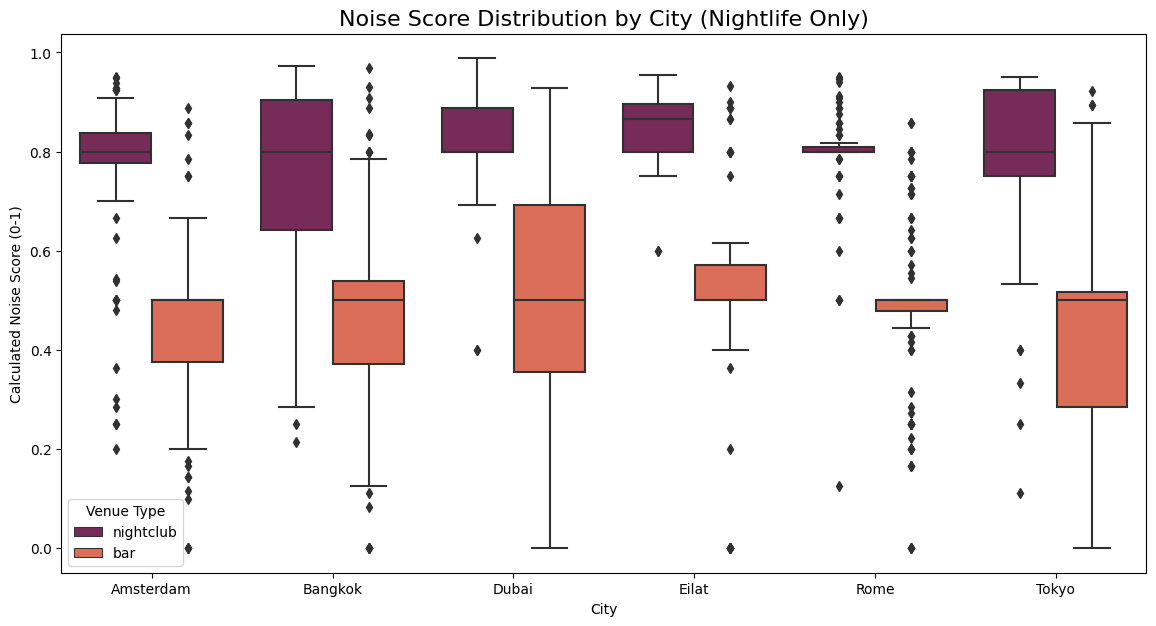

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns


nightlife_noise_pd = gmaps_clean.filter(col("poi_group") == "nightlife") \
    .select("city", "noise_score", "poi_category") \
    .toPandas()

plt.figure(figsize=(14, 7))
sns.boxplot(data=nightlife_noise_pd, x="city", y="noise_score", hue="poi_category", palette="rocket")
plt.title("Noise Score Distribution by City (Nightlife Only)", fontsize=16)
plt.ylabel("Calculated Noise Score (0-1)")
plt.xlabel("City")
plt.legend(title="Venue Type")
plt.show()

In [0]:
!pip install folium
import folium
from folium.plugins import MarkerCluster

# 1. Filter Data for Amsterdam (Convert to Pandas for plotting)
# We limit to 500 points to keep the map fast and readable
amsterdam_sample = gmaps_clean.filter(col("city") == "Amsterdam") \
    .sample(fraction=0.5, seed=42) \
    .limit(500) \
    .toPandas()

# 2. Initialize Map centered on Amsterdam
m = folium.Map(location=[52.3676, 4.9041], zoom_start=13, tiles='CartoDB positron')

# 3. Create a color map for your categories
color_map = {
    'nightlife': 'red',
    'dining': 'orange',
    'leisure': 'green',
    'tourism': 'blue',
    'family': 'purple',
    'convenience': 'gray',
    'other': 'black'
}

# 4. Add points to the map
marker_cluster = MarkerCluster().add_to(m)

for idx, row in amsterdam_sample.iterrows():
    # Handle potential missing groups
    group = row.get('poi_group', 'other')
    color = color_map.get(group, 'black')
    
    # Format vibe indicators
    vibes = []
    if row.get('vibe_tourist_trap', 0) > 0:
        vibes.append(f"Tourist Trap: {row['vibe_tourist_trap']}")
    if row.get('vibe_local_favorite', 0) > 0:
        vibes.append(f"Local Favorite: {row['vibe_local_favorite']}")
    if row.get('vibe_family_friendly', 0) > 0:
        vibes.append(f"Family Friendly: {row['vibe_family_friendly']}")
    if row.get('vibe_romantic', 0) > 0:
        vibes.append(f"Romantic: {row['vibe_romantic']}")
    if row.get('vibe_sketchy', 0) > 0:
        vibes.append(f"Sketchy: {row['vibe_sketchy']}")
    
    vibes_str = ", ".join(vibes) if vibes else "None"
    
    # Format noise mentions
    high_noise = row.get('high_noise_mentions', 0) or 0
    low_noise = row.get('low_noise_mentions', 0) or 0
    
    # Format reviews count
    num_reviews = row.get('num_of_reviews', 'N/A')
    if num_reviews is None:
        num_reviews = 'N/A'
    
    # Format rating
    rating = row.get('rating', 'N/A')
    if rating is None:
        rating = 'N/A'
    
    # Format noise score
    noise_score = row.get('noise_score', 0)
    noise_score_str = f"{noise_score:.2f}" if noise_score is not None else "N/A"
    
    # Get URL (if available)
    url = row.get('url', '')
    url_html = f'<a href="{url}" target="_blank">View on Google Maps</a>' if url else ''
    
    # Create popup text with more fields
    popup_text = f"""
    <div style="font-family: Arial, sans-serif; min-width: 250px;">
        <h4 style="margin: 0 0 8px 0; color: #333;">{row['place_name']}</h4>
        <hr style="margin: 5px 0; border: 0; border-top: 1px solid #ddd;">
        
        <b>Category:</b> {row.get('poi_category', 'N/A')}<br>
        <b>Group:</b> {row.get('poi_group', 'N/A')}<br>
        <b>Type:</b> {row.get('poi_type', 'N/A')}<br>
        
        <hr style="margin: 5px 0; border: 0; border-top: 1px solid #ddd;">
        
        <b>Rating:</b> {rating} ({num_reviews} reviews)<br>
        
        <hr style="margin: 5px 0; border: 0; border-top: 1px solid #ddd;">
        
        <b>Noise Score:</b> {noise_score_str}<br>
        <b>High Noise Mentions:</b> {high_noise}<br>
        <b>Low Noise Mentions:</b> {low_noise}<br>
        
        <hr style="margin: 5px 0; border: 0; border-top: 1px solid #ddd;">
        
        <b>Vibes:</b> {vibes_str}<br>
        
        {f'<hr style="margin: 5px 0; border: 0; border-top: 1px solid #ddd;">' + url_html if url_html else ''}
    </div>
    """
    
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=6,
        popup=folium.Popup(popup_text, max_width=350),
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7
    ).add_to(marker_cluster)

# 5. Add a Legend (HTML overlay)
legend_html = '''
     <div style="position: fixed; 
     bottom: 50px; left: 50px; width: 150px; height: 160px; 
     border:2px solid grey; z-index:9999; font-size:14px;
     background-color:white; opacity:0.8">
     &nbsp;<b>POI Groups</b><br>
     &nbsp;<i class="fa fa-circle" style="color:red"></i>&nbsp;Nightlife<br>
     &nbsp;<i class="fa fa-circle" style="color:orange"></i>&nbsp;Dining<br>
     &nbsp;<i class="fa fa-circle" style="color:green"></i>&nbsp;Leisure<br>
     &nbsp;<i class="fa fa-circle" style="color:blue"></i>&nbsp;Tourism<br>
     &nbsp;<i class="fa fa-circle" style="color:purple"></i>&nbsp;Family<br>
     &nbsp;<i class="fa fa-circle" style="color:gray"></i>&nbsp;Convenience<br>
      </div>
     '''
m.get_root().html.add_child(folium.Element(legend_html))

# Display map
m

  Obtaining dependency information for folium from https://files.pythonhosted.org/packages/b5/a8/5f764f333204db0390362a4356d03a43626997f26818a0e9396f1b3bd8c9/folium-0.20.0-py2.py3-none-any.whl.metadata
  Obtaining dependency information for branca>=0.6.0 from https://files.pythonhosted.org/packages/7e/50/fc9680058e63161f2f63165b84c957a0df1415431104c408e8104a3a18ef/branca-0.8.2-py3-none-any.whl.metadata
  Obtaining dependency information for xyzservices from https://files.pythonhosted.org/packages/ef/5c/2c189d18d495dd0fa3f27ccc60762bbc787eed95b9b0147266e72bb76585/xyzservices-2025.11.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/113.4 kB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.4/113.4 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/93.9 kB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.9/93.9 kB 7.9 MB/s eta 0:00:00
Note: you may need to restart the kernel using %restart_python or dbutils.library.re

#Crime data

In [0]:
from pyspark.sql import functions as F

# --- 1. CONFIGURATION ---
storage_account_name = "lab94290"
container_name = "submissions"
# Path to the crime folder
folder_path = "Dekel_Amit_Shoval/crime"
sas_token = "sp=rle&st=2026-01-25T10:55:58Z&se=2026-03-01T19:10:58Z&spr=https&sv=2024-11-04&sr=c&sig=jgt2r2TSHpDaCyEfTEgHAfkvEvy49xReFDS4Mg9KnOA%3D"

# Configure Spark to access the container with the SAS token
spark.conf.set(
    f"fs.azure.sas.{container_name}.{storage_account_name}.blob.core.windows.net",
    sas_token
)

# Construct the Cloud Base Path (wasbs://)
base_path = f"wasbs://{container_name}@{storage_account_name}.blob.core.windows.net/{folder_path}/"

# List of cities
cities = [
    "amsterdam", "bangkok", "dubai", "eilat", "haifa",
    "london", "new_york", "rome", "tel_aviv", "tokyo"
]

print(f"Loading crime data from: {base_path}")
print("-" * 50)

dfs = []
for city in cities:
    # Construct filename: crime_amsterdam_numbeo.csv
    file_path = f"{base_path}crime_{city}_numbeo.csv"
    
    try:
        df = spark.read.option("header", True).option("inferSchema", True).csv(file_path)
        
        # Add city column (formatted nicely)
        df = df.withColumn("city", F.lit(city.replace('_', ' ').title()))
        
        dfs.append(df)
        print(f"Loaded: {city} - {df.count()} rows")
        
    except Exception as e:
        # Check specifically for missing files vs other errors
        if "Path does not exist" in str(e) or "FileNotFound" in str(e):
             print(f"Warning: File not found for {city} (crime_{city}_numbeo.csv)")
        else:
             print(f"Error loading {city}: {e}")

# Combine all DataFrames
if dfs:
    combined_df = dfs[0]
    for df in dfs[1:]:
        combined_df = combined_df.unionByName(df, allowMissingColumns=True)
    
    # Print Schema
    print("\n=== Schema ===")
    combined_df.printSchema()
    
    # Print column names
    print("\n=== Columns ===")
    print(combined_df.columns)
    
    # Summary info
    print(f"\n=== Summary ===")
    print(f"Total rows: {combined_df.count()}")
    print(f"Total columns: {len(combined_df.columns)}")
    
    # Show sample data
    print("\n=== Sample Data ===")
    display(combined_df.limit(10))

    # Write to DBFS (Silver layer)
    output_path = "dbfs:/FileStore/project/silver/crime_numbeo"
    combined_df.write \
        .mode("overwrite") \
        .partitionBy("city") \
        .parquet(output_path)

    print(f"Saved to: {output_path}")

else:
    print("\nNo data was loaded. Please check if the file names in the cloud match 'crime_{city}_numbeo.csv'.")

Loading crime data from: wasbs://submissions@lab94290.blob.core.windows.net/Dekel_Amit_Shoval/crime/
--------------------------------------------------
Loaded: amsterdam - 15 rows
Loaded: bangkok - 15 rows
Loaded: dubai - 15 rows
Loaded: eilat - 15 rows
Loaded: haifa - 15 rows
Loaded: london - 15 rows
Loaded: new_york - 15 rows
Loaded: rome - 15 rows
Loaded: tel_aviv - 15 rows
Loaded: tokyo - 15 rows

=== Schema ===
root
 |-- city: string (nullable = false)
 |-- country: string (nullable = true)
 |-- metric: string (nullable = true)
 |-- score: double (nullable = true)
 |-- level: string (nullable = true)
 |-- source: string (nullable = true)
 |-- last_update: date (nullable = true)


=== Columns ===
['city', 'country', 'metric', 'score', 'level', 'source', 'last_update']

=== Summary ===
Total rows: 150
Total columns: 7

=== Sample Data ===


city,country,metric,score,level,source,last_update
Amsterdam,Netherlands,Level of crime,31.75,Low,Numbeo,2026-01-18
Amsterdam,Netherlands,Crime increasing in the past 5 years,51.53,Moderate,Numbeo,2026-01-18
Amsterdam,Netherlands,Worries home broken and things stolen,26.96,Low,Numbeo,2026-01-18
Amsterdam,Netherlands,Worries being mugged or robbed,26.81,Low,Numbeo,2026-01-18
Amsterdam,Netherlands,Worries car stolen,21.66,Low,Numbeo,2026-01-18
Amsterdam,Netherlands,Worries things from car stolen,32.6,Low,Numbeo,2026-01-18
Amsterdam,Netherlands,Worries attacked,25.52,Low,Numbeo,2026-01-18
Amsterdam,Netherlands,Worries being insulted,29.69,Low,Numbeo,2026-01-18
Amsterdam,Netherlands,Worries physical attack due to discrimination,21.46,Low,Numbeo,2026-01-18
Amsterdam,Netherlands,Problem people using or dealing drugs,43.17,Moderate,Numbeo,2026-01-18


Saved to: dbfs:/FileStore/project/silver/crime_numbeo


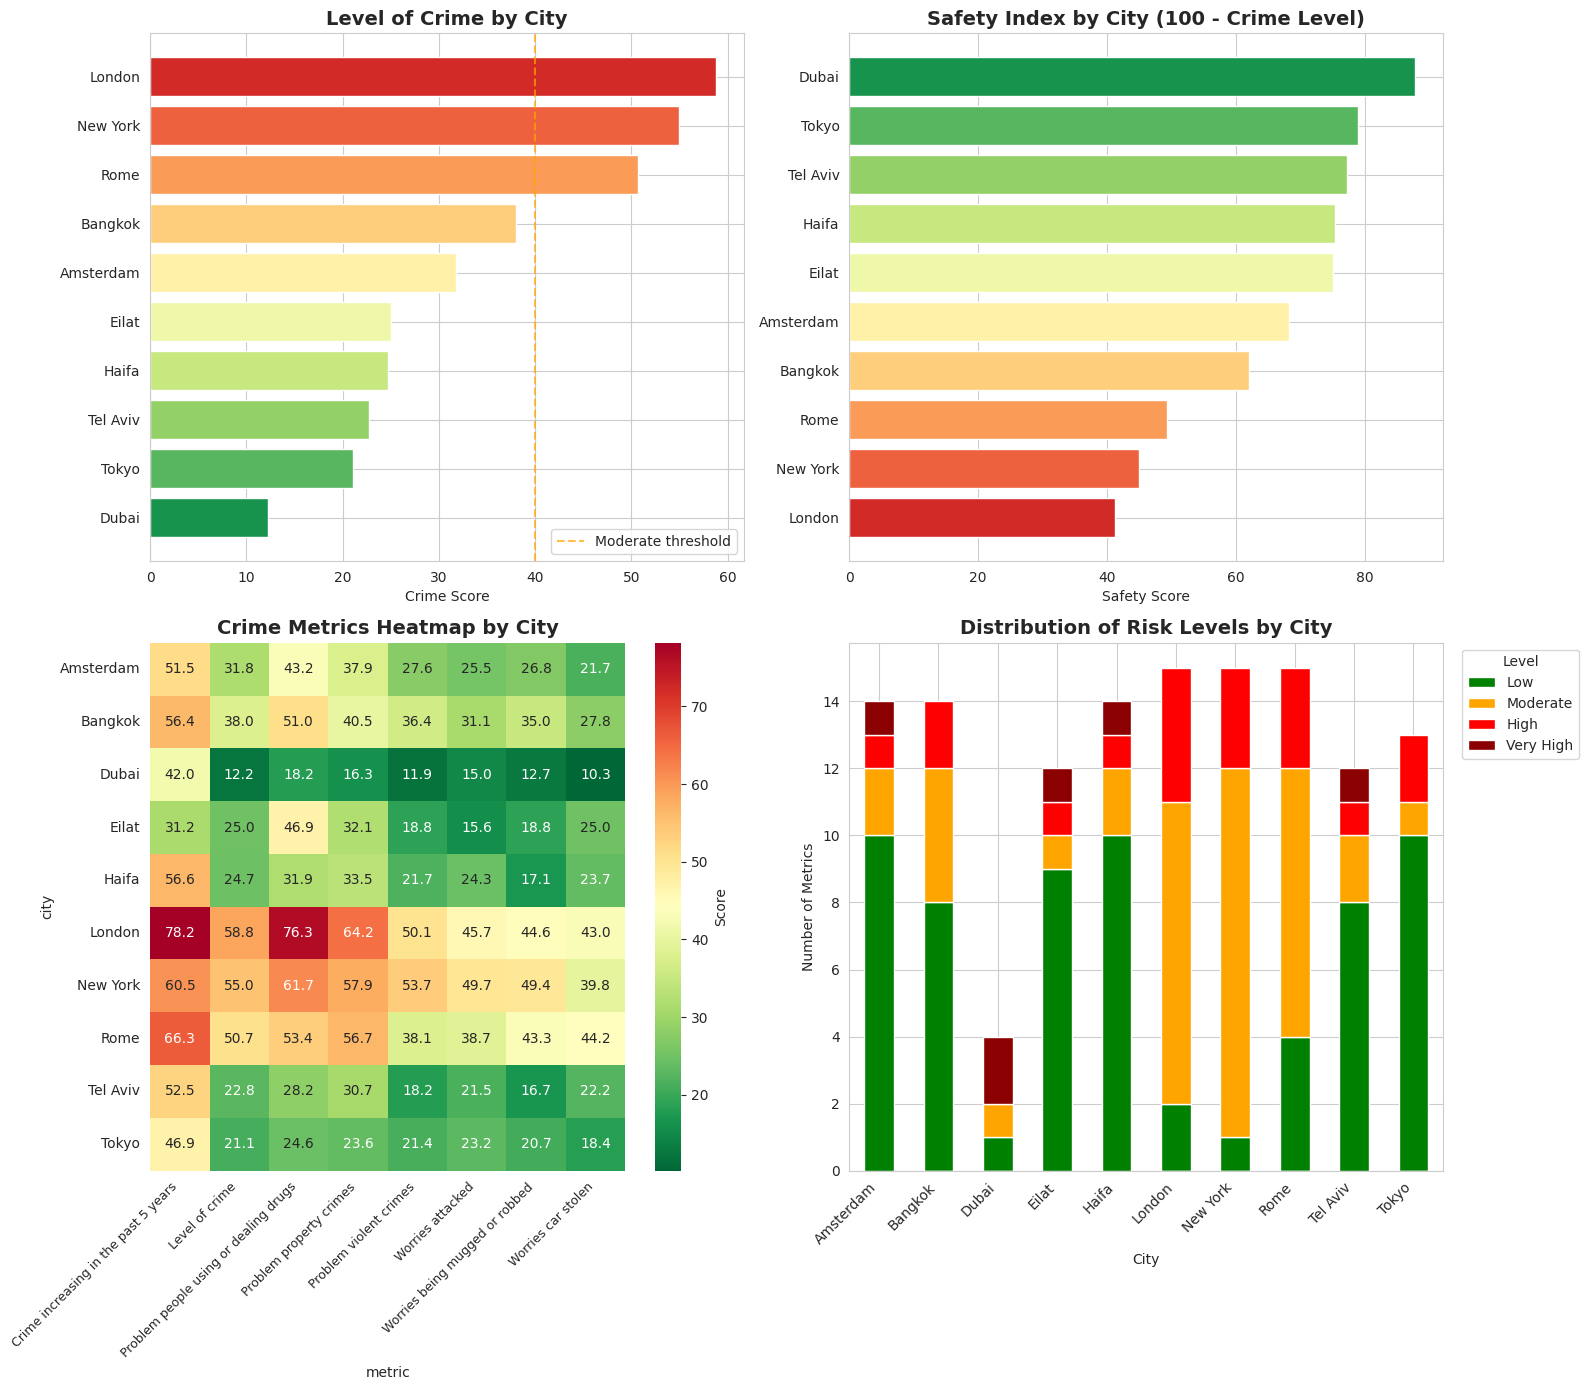

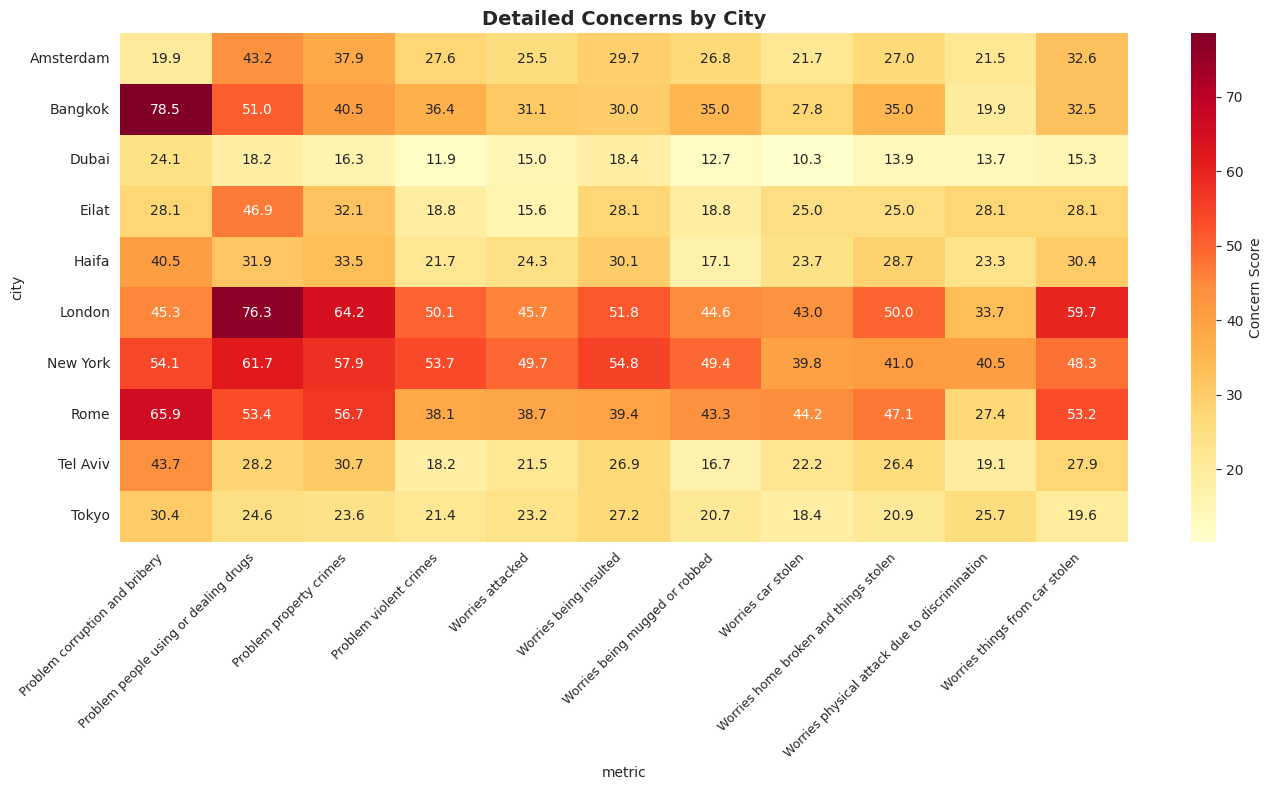


=== Crime Level Summary ===


city,country,score,level
Dubai,United Arab Emirates,12.24,Very Low
Tokyo,Japan,21.08,Low
Tel Aviv,Israel,22.77,Low
Haifa,Israel,24.69,Low
Eilat,Israel,25.0,Low
Amsterdam,Netherlands,31.75,Low
Bangkok,Thailand,38.0,Low
Rome,Italy,50.7,Moderate
New York,United States,54.98,Moderate
London,Canada,58.77,Moderate


In [0]:


import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert to Pandas for visualization
pdf = combined_df.toPandas()

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.facecolor'] = 'white'

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Overall Crime Level by City
ax1 = axes[0, 0]
crime_level = pdf[pdf['metric'] == 'Level of crime'].sort_values('score', ascending=True)
colors = sns.color_palette("RdYlGn_r", len(crime_level))
ax1.barh(crime_level['city'], crime_level['score'], color=colors)
ax1.set_xlabel('Crime Score')
ax1.set_title('Level of Crime by City', fontsize=14, fontweight='bold')
ax1.axvline(x=40, color='orange', linestyle='--', alpha=0.7, label='Moderate threshold')
ax1.legend()

# 2. Safety Index by City (if exists, otherwise use inverse of crime)
ax2 = axes[0, 1]
if 'Safety index' in pdf['metric'].values:
    safety = pdf[pdf['metric'] == 'Safety index'].sort_values('score', ascending=False)
else:
    # Calculate safety as 100 - crime level
    safety = crime_level.copy()
    safety['score'] = 100 - safety['score']
    safety = safety.sort_values('score', ascending=True)
colors = sns.color_palette("RdYlGn", len(safety))
ax2.barh(safety['city'], safety['score'], color=colors)
ax2.set_xlabel('Safety Score')
ax2.set_title('Safety Index by City (100 - Crime Level)', fontsize=14, fontweight='bold')

# 3. Heatmap of All Metrics by City
ax3 = axes[1, 0]
pivot_df = pdf.pivot_table(index='city', columns='metric', values='score', aggfunc='mean')
# Select key metrics for readability
key_metrics = [col for col in pivot_df.columns if any(x in col.lower() for x in ['crime', 'attack', 'mugged', 'stolen', 'drug'])]
if len(key_metrics) > 0:
    pivot_subset = pivot_df[key_metrics[:8]]  # Limit to 8 metrics
    sns.heatmap(pivot_subset, annot=True, fmt='.1f', cmap='RdYlGn_r', ax=ax3, cbar_kws={'label': 'Score'})
    ax3.set_title('Crime Metrics Heatmap by City', fontsize=14, fontweight='bold')
    plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right', fontsize=9)
    plt.setp(ax3.yaxis.get_majorticklabels(), fontsize=10)

# 4. Level Distribution by City (Stacked Bar)
ax4 = axes[1, 1]
level_counts = pdf.groupby(['city', 'level']).size().unstack(fill_value=0)
level_order = ['Low', 'Moderate', 'High', 'Very High']
level_counts = level_counts[[col for col in level_order if col in level_counts.columns]]
level_counts.plot(kind='bar', stacked=True, ax=ax4, color=['green', 'orange', 'red', 'darkred'][:len(level_counts.columns)])
ax4.set_xlabel('City')
ax4.set_ylabel('Number of Metrics')
ax4.set_title('Distribution of Risk Levels by City', fontsize=14, fontweight='bold')
ax4.legend(title='Level', bbox_to_anchor=(1.02, 1))
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

# --- Additional: Top Concerns by City ---
fig2, ax5 = plt.subplots(figsize=(14, 8))
worry_metrics = pdf[pdf['metric'].str.contains('Worries|Problem', case=False)]
pivot_worries = worry_metrics.pivot_table(index='city', columns='metric', values='score', aggfunc='mean')
sns.heatmap(pivot_worries, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax5, cbar_kws={'label': 'Concern Score'})
ax5.set_title('Detailed Concerns by City', fontsize=14, fontweight='bold')
plt.setp(ax5.xaxis.get_majorticklabels(), rotation=45, ha='right', fontsize=9)
plt.tight_layout()
plt.show()

# --- Summary Table ---
print("\n=== Crime Level Summary ===")
summary = pdf[pdf['metric'] == 'Level of crime'][['city', 'country', 'score', 'level']].sort_values('score')
display(summary)